<a href="https://colab.research.google.com/github/saugatabose28/work/blob/main/OCSVM_try_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==3.0.0
!pip install emoji
!pip install onnx onnxruntime
!pip install scikit-plot
!pip install plot-metric
!pip install pyod
!pip install transformers[onnx]
import tensorflow as tf
import gc

import os
os.environ['PYTHONHASHSEED']=str(1)

import random
import emoji as emoji
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from numpy import dstack
from numpy import mean
from numpy import std
from numpy.linalg import norm
from transformers import AutoModel
from transformers import BertModel, BertTokenizer
# optimizer from hugging face transformers
from transformers import AdamW
from pyod.models.ocsvm import OCSVM
from pyod.utils.example import visualize#generate dataset
data_path="drive/My Drive/Colab Notebooks"
from google.colab import drive
drive.mount('/content/drive')

In [2]:
class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.lstm = nn.LSTM(768, 128,2,batch_first=True,bidirectional=True)
        self.fc = nn.Linear(128*2, 1) 

        weights_= (self.fc.weight)
        
        #weights__=(torch.transpose(weights_, 0, 1))
        self.weights=(torch.transpose(weights_, 0, 1))
          #biases1= (self.fc.bias.data.fill_(0.01))
        #print(weights_.size(), self.weights.size())
        self.bias= self.fc.bias

        #self.register_parameter('bias', nn.Parameter(self.bias,requires_grad=True))
        #self.register_parameter('weights', nn.Parameter(weights__))
        self.r=self.bias.to(device)


    def forward(self, ids, mask):
          sequence_output, pooled_output = self.bert(ids,attention_mask=mask)          
          lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings

          hidden = torch.cat((lstm_output[:,-1, :128],lstm_output[:,0, 128:]),dim=-1)
          hidden=hidden.view(-1,128*2)

          weights=self.weights
          biases=self.bias
          r=self.r
          #print(weights, biases,r)
          #output=self.fc(hidden.view(-1,128*2))     
          output=torch.matmul(hidden,weights)+biases             
          prediction=(output-self.r)
          
          #weights.retain_grad()
          #biases.retain_grad()
          #self.r.retain_grad()
          #print("\n",biases)
          return prediction,weights,biases,r,output

def init_bias(m):
  if isinstance(m, nn.Linear):
    #torch.nn.init.xavier_uniform(m.weight)
    m.bias.data.fill_(-1)

def read_dataset():
    data = pd.read_csv(f"{data_path}/preProcessedDavidson_90Hate.csv")
    return data['tweet'].tolist(), data['class']


def data_process(data, labels):
    input_ids = []
    attention_masks = []
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    for sentence in data:
        bert_inp = bert_tokenizer.__call__(sentence, max_length=12,
                                           padding='max_length', pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)

        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])

    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    d=np.array(data)
    return input_ids, attention_masks, labels,d

def load_and_process():
    data, labels = read_dataset()
    num_of_labels = len(labels.unique())
    #input_ids, attention_masks, labels = data_process(pre_process_dataset(data), labels)
    input_ids, attention_masks, labels,d = data_process(data, labels)

    return input_ids, attention_masks, labels,d


# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    
    #train_preds = []
    # iterate over batches
    total = len(train_dataloader)
    correct=0
    #print(total)
    for i, batch in enumerate(train_dataloader):
        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>'  *(filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [b.to(device) for b in batch]
        sent_id, mask, labels = batch

        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # clear previously calculated gradients
        model.zero_grad()
        #print((sent_id.size()))
        ####for NLLL,hinge loss,multi####
        prediction,weights,biases,r,output = model(sent_id, mask)
                      
        #########Custom loss
        loss = OCSVM_loss(weights,biases,output,r)
        #print(tf.math.reduce_mean(loss.item()))
        print(" training loss %f" %loss.item())
        #####################

        # add on to the total loss
        total_loss += float(loss.item())
        
 
        # backward pass to calculate the gradients
        #print("\n")
        #loss.register_hook(lambda grad: print(grad))
        loss.backward()
        print("after:")
        #for name, param in model.named_parameters():
        #   print(name, param.grad)
        print(model.fc.weight.grad.size())
        print(model.r.grad)
        #print("\n graduent bias: ")
        #print(biases.grad)



        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        #total_preds.append(prediction)

        # update parameters
        optimizer.step() 
    #print(model.fc.bias)
    gc.collect()
    torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / (len(train_dataloader)*batch_size)

    accu=100.*correct/total
    
    ##for NLL, hinge,multimargin loss only##
    #total_preds = np.concatenate(total_preds, axis=0)
    ##

    # returns the loss and predictions
    ##for NLL, hinge,multimargin##
    return avg_loss

# function for evaluating the model
def evaluate():
    print("\n\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    #total_preds = []
    val_preds = []

    # iterate over batches
    total = len(val_dataloader)
    correct=0
    for i, batch in enumerate(val_dataloader):
        
        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # deactivate autograd
        with torch.no_grad():

            # model predictions
            ##for NLL, hinge,multimargin loss##
            prediction,weights,biases,r,output = model(sent_id, mask)
            #correct += prediction.eq(labels).sum().item()
            loss = OCSVM_loss(weights,biases,output,r)
            print(" validation loss %f" %loss.item())
            #########

            total_loss += float(loss.item())
            #total_preds.append(prediction)
            #val_preds.append(prediction)
    
    gc.collect()
    torch.cuda.empty_cache()

    # compute the validation loss of the epoch
    avg_loss = total_loss / (len(val_dataloader)*batch_size)

    return avg_loss

def OCSVM_loss(weight,bias,output,r):

    a=0.5*torch.square(torch.linalg.norm((weight)))
    temp=r-output
    z = torch.zeros_like((temp))
    #b=torch.tensor([torch.mean(torch.maximum(z,temp))])
    b=[torch.mean(torch.maximum(z,temp))]
    #print(b)
    #print(a)
    l2 = a+(1/(0.01))*b[0]-r  
    
    return l2

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

reset_random_seeds()
# Specify the GPU
# Setting up the device for GPU usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Load Data-set ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
input_ids, attention_masks, labels,text = load_and_process()
df = pd.DataFrame(list(zip(input_ids, attention_masks)), columns=['input_ids', 'attention_masks'])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ class distribution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
# ~~~~~~~~~~ Split train data-set into train, validation and test sets  ~~~~~~~~~~#
train_text, val_text, train_labels, val_labels = train_test_split(df, labels,
                            random_state=2018, test_size=0.2, stratify=labels)

#del temp_text
gc.collect()
torch.cuda.empty_cache()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~ Import BERT Model and BERT Tokenizer ~~~~~~~~~~~~~~~~~~~~~#
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Tokenization ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for train set
train_seq = torch.tensor(df['input_ids'].tolist())
train_mask = torch.tensor(df['attention_masks'].tolist())
train_y = torch.tensor(labels.tolist())

# for validation set
val_seq = torch.tensor(val_text['input_ids'].tolist())
val_mask = torch.tensor(val_text['attention_masks'].tolist())
val_y = torch.tensor(val_labels.tolist())

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Create DataLoaders ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Freeze BERT Parameters ~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
# push the model to GPU
model = model.to(device)
model.apply(init_bias)

# define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# set initial loss to infinite
best_valid_loss = float('inf')

epochs = 20
current = 1
# empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []
#global co
while current <= epochs:

    print(f'\nEpoch {current} / {epochs}:')

    # train model
    
    train_loss= train()
    # evaluate model
    
    valid_loss= evaluate()

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'saved_weights.pth')

        # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    

    print(f'\n\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    current = current + 1

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:265: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)



Epoch 1 / 20:
Batch 1/45 |██>.................................................................................................| 2.22% complete, loss=0.00, accuracy=0 training loss 1.173816
after:
torch.Size([1, 256])
tensor([-1.])
Batch 2/45 |████>...............................................................................................| 4.44% complete, loss=0.00, accuracy=0 training loss 1.286506
after:
torch.Size([1, 256])
tensor([-1.])
Batch 3/45 |██████>.............................................................................................| 6.67% complete, loss=0.00, accuracy=0 training loss 1.173517
after:
torch.Size([1, 256])
tensor([-1.])
Batch 4/45 |████████>...........................................................................................| 8.89% complete, loss=0.00, accuracy=0 training loss 1.173375
after:
torch.Size([1, 256])
tensor([-1.])
Batch 5/45 |███████████>........................................................................................| 11.

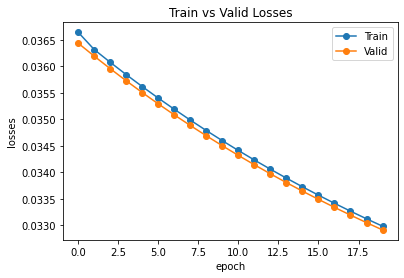

In [3]:
plt.plot(train_losses,'-o')
plt.plot(valid_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses') 
plt.show()


In [4]:
gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    predsTrain,weights,biases,r,output = model(train_seq.to(device), train_mask.to(device))
    #print(predsTrain)
preds=(torch.where(predsTrain >0, 0, 1))
print('Classification Report-Train')
print(classification_report(train_y, preds))

with torch.no_grad():
    predsValid,weights,biases,r,output = model(val_seq.to(device), val_mask.to(device))
    #print(predsValid)
preds=(torch.where(predsValid >0, 0, 1))
print('Classification Report-Valid')
print(classification_report(val_y, preds))

Classification Report-Train
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1281
           1       0.00      0.00      0.00       143

    accuracy                           0.90      1424
   macro avg       0.45      0.50      0.47      1424
weighted avg       0.81      0.90      0.85      1424



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report-Valid
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       256
           1       0.00      0.00      0.00        29

    accuracy                           0.90       285
   macro avg       0.45      0.50      0.47       285
weighted avg       0.81      0.90      0.85       285



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
def data_process(data, labels):
    input_ids = []
    attention_masks = []
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    for sentence in data:
        bert_inp = bert_tokenizer.__call__(sentence, max_length=12,
                                           padding='max_length', pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)

        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])
    #del bert_tokenizer
    #gc.collect()
    #torch.cuda.empty_cache()
    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    d=np.array(data)
    return input_ids, attention_masks, labels,d
def read_dataset():
    data = pd.read_csv(f"{data_path}/preProcessed_Davidson_10Hate_forTest.csv")
    #data = data.drop(['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)
    #data = data.loc[0:9599,:]
    print(len(data))
    return data['tweet'].tolist(), data['class']
def load_and_process():
    data, labels = read_dataset()
    num_of_labels = len(labels.unique())
    #input_ids, attention_masks, labels = data_process(pre_process_dataset(data), labels)
    input_ids, attention_masks, labels,d = data_process(data, labels)
    return input_ids, attention_masks, labels,d

input_ids, attention_masks, labels,text = load_and_process()
df = pd.DataFrame(list(zip(input_ids, attention_masks)), columns=['input_ids', 'attention_masks'])
test_seq = torch.tensor(df['input_ids'].tolist())
test_mask = torch.tensor(df['attention_masks'].tolist())
test_y = torch.tensor(labels.tolist())

with torch.no_grad():
    predsTest,weights,biases,r,output = model(test_seq.to(device), test_mask.to(device))
    print(predsTest)
preds=(torch.where(predsTest >0, 0, 1))
print('Classification Report-Test')
print(classification_report(test_y, preds))

287
tensor([[0.1931],
        [0.1924],
        [0.1910],
        [0.1956],
        [0.2006],
        [0.1945],
        [0.2018],
        [0.1876],
        [0.2006],
        [0.1959],
        [0.1985],
        [0.1986],
        [0.1900],
        [0.1873],
        [0.1986],
        [0.1970],
        [0.1943],
        [0.1996],
        [0.1939],
        [0.1937],
        [0.1905],
        [0.1930],
        [0.1915],
        [0.1894],
        [0.1907],
        [0.1844],
        [0.1896],
        [0.1994],
        [0.1949],
        [0.1931],
        [0.1929],
        [0.1953],
        [0.1895],
        [0.1917],
        [0.1974],
        [0.1949],
        [0.1912],
        [0.1983],
        [0.1906],
        [0.1914],
        [0.2000],
        [0.1887],
        [0.1894],
        [0.1984],
        [0.1977],
        [0.1911],
        [0.1919],
        [0.1936],
        [0.1959],
        [0.1914],
        [0.2006],
        [0.1990],
        [0.1992],
        [0.1921],
        [0.2037],
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
